# Handling missing or unbalanced numerical data

General best thing to do in that scenario is to try to get more data.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import make_classification
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
import imblearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
def get_random_data(lower_bound=-10, upper_bound=10, n_rows=100, n_cols=2, column_names=list('AB'), with_missing_data=False):
    df = pd.DataFrame(np.random.uniform(lower_bound, upper_bound, [n_rows, n_cols]), columns=column_names)
    
    if with_missing_data:
        for column_name in column_names:
            nan_index = df[column_name].sample(frac=0.2).index
            df[column_name][nan_index] = np.NaN
    return df

## Missing data

### Dropping

Simplest way to handle missing data but also the less likely to be what we need.

In [3]:
df = pd.DataFrame({"name": ['Alfred', 'Batman', 'Catwoman'],
                   "toy": [np.nan, 'Batmobile', 'Bullwhip'],
                   "born": [pd.NaT, pd.Timestamp("1940-04-25"),
                            pd.NaT]})
df

,name,toy,born
0,Alfred,NaN,NaT
1,Batman,Batmobile,1940-04-25
2,Catwoman,Bullwhip,NaT


In [4]:
df.dropna()

,name,toy,born
1,Batman,Batmobile,1940-04-25


In [5]:
df.dropna(axis='columns')

,name
0,Alfred
1,Batman
2,Catwoman


### Mean / median replacement

Not the best practice since we are very sensitive to outliers, only works on columns and we might miss correlations between features.

This is an easy solution if very few data is missing.

In [6]:
df = get_random_data(with_missing_data=True)
df.head()

,A,B
0,8.061676,2.871890
1,-9.936047,-5.496189
2,2.113653,NaN
3,3.673325,-7.656244
4,-1.100754,9.095399


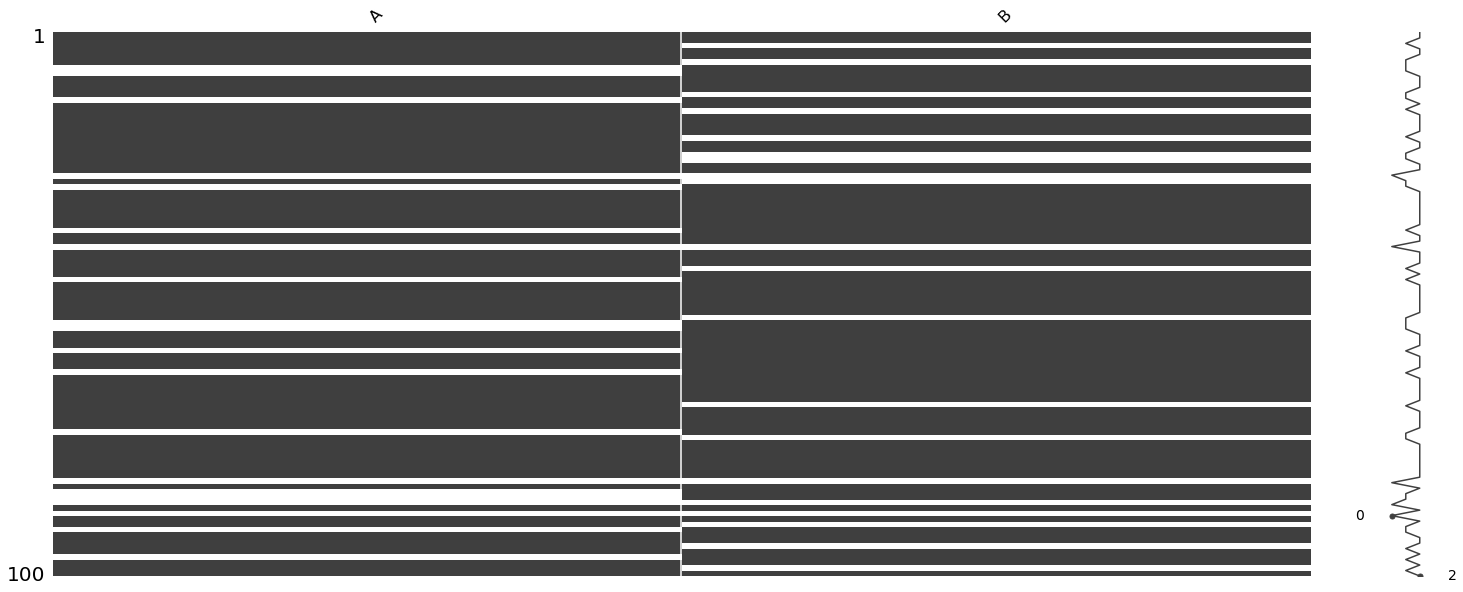

In [7]:
missingdata_df = df.columns[df.isnull().any()].tolist()
msno.matrix(df[missingdata_df])

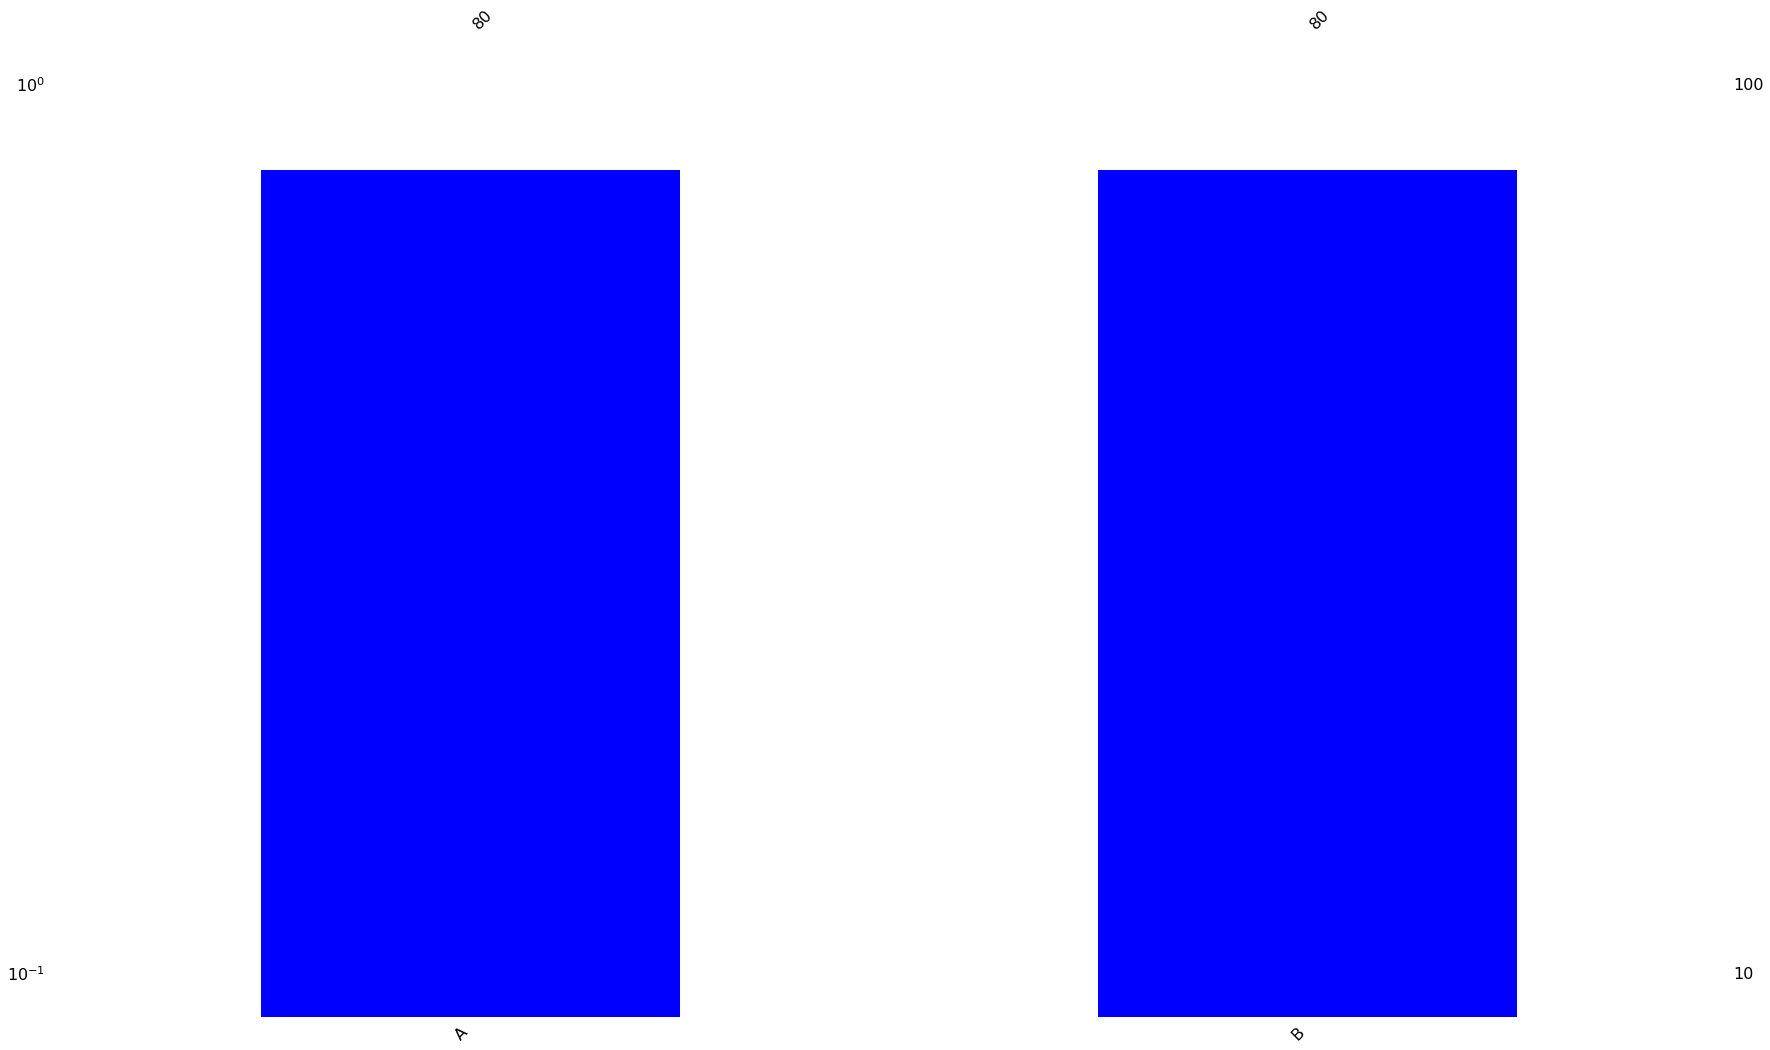

In [8]:
msno.bar(df[missingdata_df], color="blue", log=True, figsize=(30, 18))

In [9]:
df = df.fillna(df.mean())

In [10]:
df.head()

,A,B
0,8.061676,2.871890
1,-9.936047,-5.496189
2,2.113653,0.485741
3,3.673325,-7.656244
4,-1.100754,9.095399


### Forward and backward fill

Replace NaN with non NaN values from before or after. Can be useful with time series data.

In [11]:
df = pd.DataFrame([[np.nan, 2, np.nan, 0],
                   [np.nan, np.nan, np.nan, 5],
                   [np.nan, 3, np.nan, 4]],
                  columns=list('ABCD'))
df

,A,B,C,D
0,NaN,2.0,NaN,0
1,NaN,NaN,NaN,5
2,NaN,3.0,NaN,4


In [12]:
df.fillna(method='ffill')

,A,B,C,D
0,NaN,2.0,NaN,0
1,NaN,2.0,NaN,5
2,NaN,3.0,NaN,4


In [13]:
df.fillna(method='bfill')

,A,B,C,D
0,NaN,2.0,NaN,0
1,NaN,3.0,NaN,5
2,NaN,3.0,NaN,4


### Interpolation

In [14]:
df = get_random_data(with_missing_data=True)
df.head()

,A,B
0,8.940333,-4.043891
1,NaN,NaN
2,-0.319704,-8.151366
3,-5.944679,5.435286
4,8.966171,6.263018


In [15]:
df.mean()

A    0.715223
B   -0.229974
dtype: float64

In [16]:
df.interpolate(method='linear', axis=0).ffill().bfill().mean()

A    0.689256
B   -0.244047
dtype: float64

### Supervised learning to predict missing values

Find the features which are most correlated to the missing values we want to predict and create a model to predict them (KNN, ...)

### Multiple Imputation by Chained Equations (MICE)

find linear or non linear relationships between the missing feature and other features

In [17]:
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])

IterativeImputer(random_state=0)

In [18]:
X = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
imp_mean.transform(X)

array([[ 6.95847623,  2.        ,  3.        ],
       [ 4.        ,  2.6000004 ,  6.        ],
       [10.        ,  4.99999933,  9.        ]])

## Unbalanced data

We have a large number of samples for a category compared to others. The model will likely forget about it during training if the data does not contain enough element.

In [19]:
def get_unbalanced_data():
    return pd.read_csv('data/breast_cancer.csv')

### Oversampling (sampling with replacement)

Add copies of instances from the minority class.

To do that, we need to analyze the variance of the features for the minority samples. New data should be generated within these ranges.

In [20]:
df = get_unbalanced_data()
df.head()

,recurrence,age,menopause,tumor_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,has_cancer
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   recurrence   286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor_size   286 non-null    object
 4   inv_nodes    286 non-null    object
 5   node_caps    286 non-null    object
 6   deg_malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast_quad  286 non-null    object
 9   has_cancer   286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


In [22]:
d = df.has_cancer.value_counts().to_dict()
d

{'no': 218, 'yes': 68}

In [23]:
yfreq = pd.DataFrame(data={
    "no": [218],
    "yes": [68]
})
yfreq

,no,yes
0,218,68


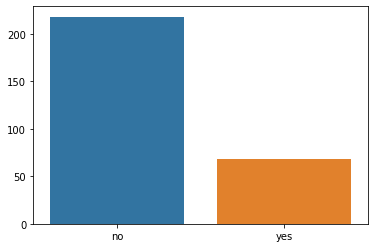

In [24]:
sns.barplot(data=yfreq)

In [25]:
max_size = df['has_cancer'].value_counts().max()
max_size

218

In [26]:
copy = [df]
for class_index, group in df.groupby('has_cancer'):
    copy.append(group.sample(max_size - len(group), replace=True))
oversampled_df = pd.concat(copy)

In [27]:
d = oversampled_df.has_cancer.value_counts().to_dict()
d

{'yes': 218, 'no': 218}

#### SMOTE (Synthetitc Minority Over-Sampling Technique)

Select examples close in the feature space. This uses KNN.

In [28]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

In [29]:
df = pd.DataFrame(X, columns=["feature_1", "feature_2"])
df["label"] = pd.DataFrame(y, columns=["label"])
df.head()

,feature_1,feature_2,label
0,0.222014,0.540207,0
1,1.347439,1.412824,0
2,0.537238,0.372730,0
3,2.134462,1.404819,0
4,2.315827,1.356858,0


In [30]:
counter = Counter(df["label"])
counter

Counter({0: 9900, 1: 100})

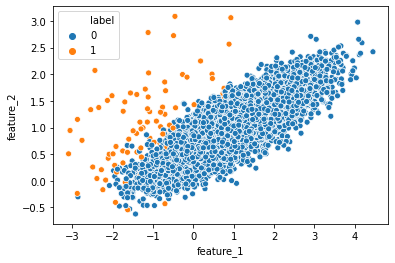

In [31]:
sns.scatterplot(x=df.feature_1, y=df.feature_2, hue=df["label"])

In [32]:
oversample = imblearn.over_sampling.SMOTE()
X, y = oversample.fit_resample(X, y)

In [33]:
df = pd.DataFrame(X, columns=["feature_1", "feature_2"])
df["label"] = pd.DataFrame(y, columns=["label"])
df.head()

,feature_1,feature_2,label
0,0.222014,0.540207,0
1,1.347439,1.412824,0
2,0.537238,0.372730,0
3,2.134462,1.404819,0
4,2.315827,1.356858,0


In [34]:
Counter(df["label"])

Counter({0: 9900, 1: 9900})

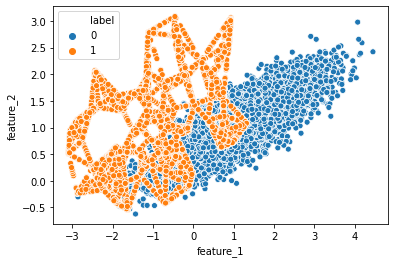

In [35]:
sns.scatterplot(x=df.feature_1, y=df.feature_2, hue=df["label"])

#### ROSE (Randomly Over Sampling Examples)

In [36]:
X, y = make_classification(n_samples=10000, weights=[0.99], flip_y=0)

In [37]:
Counter(y)

Counter({0: 9900, 1: 100})

In [38]:
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)

In [39]:
Counter(y_over)

Counter({0: 9900, 1: 9900})

### Undersampling

delete instances from the majority class, not really good because we lose information.

In [40]:
X, y = make_classification(n_samples=10000, weights=[0.99], flip_y=0)

In [41]:
Counter(y)

Counter({0: 9900, 1: 100})

In [42]:
undersample = imblearn.under_sampling.RandomUnderSampler(sampling_strategy='majority')
X_over, y_over = undersample.fit_resample(X, y)

In [43]:
Counter(y_over)

Counter({0: 100, 1: 100})

### Combining both oversampling and understampling

Can sometimes get good results by undersampling a little bit the majority class and oversampling a little bit the minority class.

In [44]:
X, y = make_classification(n_samples=10000, weights=[0.99], flip_y=0)

In [45]:
Counter(y)

Counter({0: 9900, 1: 100})

In [46]:
over = imblearn.over_sampling.RandomOverSampler(sampling_strategy=0.1)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)

In [47]:
steps = [('o', over), ('u', under), ('m', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
np.mean(scores)

0.9685666666666666

### Adjusting thresholds

Default threshold is 0.5 for a balanced dataset. The threshold can be moved depending on the business case (more importance for FP than FN, ...)

For unbalanced dataset, ajudsting the thresholds can be easy and effective.

In [48]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)


In [49]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)

LogisticRegression()

In [50]:
preds = model.predict(X_test)
score = f1_score(y_test, preds)
score

0.7012987012987013

In [51]:
y_hat = model.predict_proba(X_test)
probs = y_hat[:, 1] # keep proba for positive outcome only
thresholds = np.arange(0, 1, 0.001)

In [52]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

In [53]:
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]

In [54]:
# get best threshold
index_max = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[index_max], scores[index_max]))

Threshold=0.251, F-Score=0.75556
